In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
import netCDF4 as nc
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.errors import RasterioIOError
from shapely.geometry import Point
import time
from scipy.spatial import cKDTree

In [42]:
def clip_or_assign_nearest(netCDF_file, geopackage_file, min_size):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        affine = src.transform

        # Adjust to handle multiple bands (timesteps)
        result_data = []
        for band in range(1, src.count + 1):
            data = src.read(band)
            band_data = np.full(data.shape, np.nan)

            for _, row in geopackage_gdf.iterrows():
                if row.geometry.area < min_size:
                    # For small areas, assign the nearest neighbor value
                    centroid = row.geometry.centroid
                    x, y = centroid.x, centroid.y
                    row_idx, col_idx = ~affine * (x, y)
                    row_idx, col_idx = int(row_idx), int(col_idx)
                    
                    if 0 <= row_idx < data.shape[0] and 0 <= col_idx < data.shape[1]:
                        nearest_value = data[row_idx, col_idx]
                        band_data[row_idx, col_idx] = nearest_value
                else:
                    # For larger areas, clip the data
                    clipped_data, _ = mask(src, [row.geometry], crop=True, nodata=np.nan)
                    # Logic to merge clipped_data into band_data

            result_data.append(band_data)

        meta = src.meta.copy()

    return np.array(result_data), meta

In [51]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'catchments')
    shape_path = os.path.join(data, 'data_tana', 'catchments', 'goeie')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")
print(data_path)

Welcome Mats , have a wondeful day on your Darwin machine. Your data should be located in /Users/matskerver/Documents/data_tana/catchments
/Users/matskerver/Documents/data_tana/catchments


In [52]:
# print(data_path)

# path_subcatchments = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data','Shapefiles', 'Mini_shapes')
# path_satellite = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')
# path_save_new_shapefiles = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'subcatchments_chirps')

# shapefiles_fnames = os.path.join(path_subcatchments, '*.gpkg')
# shape_files = glob.glob(shapefiles_fnames)
# path_satellite = path_satellite.replace('\\', '\\\\')

# print(path_satellite)

# N = len(shapefiles_fnames)

In [53]:
data_files = glob.glob(os.path.join(data_path, '*.nc'))
print(data_files)
datasets = {}

for file_path in data_files:
    # Extract the file identifier from the file name
    file_name = os.path.basename(file_path)  # Get just the file name
    file_identifier = file_name.split('_')[0]  # Split by underscore and take the first part
    # print(file_identifier)
    # Open the dataset
    dataset = xr.open_dataset(file_path)
    # print(dataset)
    # Add the file identifier as a new coordinate
    dataset = dataset.assign_coords(file_identifier=file_identifier)
    
    # Add the dataset to the dictionary with the file identifier as the key
    datasets[file_identifier] = dataset
    # print(datasets[file_identifier])
chirps_file = data_files[0]

['/Users/matskerver/Documents/data_tana/catchments/chirps_2018_2022_28.45_43.55_-5.05_5.45.nc']


<Axes: >

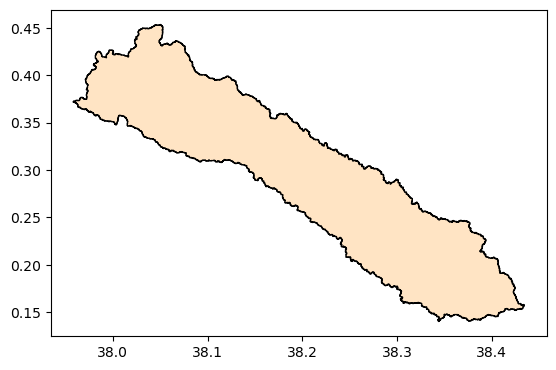

In [54]:
shape_file = os.path.join(shape_path, '*.gpkg')
shape_files = glob.glob(shape_file)

gdfs = []

for file in shape_files:
    gdf = gpd.read_file(file)
    gdfs.append(gdf)

merged_gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
merged_gdfs.plot(color = 'bisque', edgecolor = 'black')

In [55]:
#gdfs

In [56]:
i = 0
start_time = time.time()
min_size = 100  # minimum size in the units of the GeoPackage's CRS
netCDF_file = data_files[0]  # Assuming data_files contains the list of NetCDF file paths
for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data, meta = clip_or_assign_nearest(netCDF_file, geopackage_file, min_size)
    print(geopackage_file)
    i += 1
    if i > 20:
        break;
    print(clipped_data.shape)
# clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/Users/matskerver/Documents/data_tana/catchments/goeie/fid_1.gpkg
(1826, 210, 302)
/Users/matskerver/Documents/data_tana/catchments/goeie/fid_144.gpkg
(1826, 210, 302)
Execution time: 327.9166851043701 seconds


In [26]:
def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the NetCDF data
        data = src.read(1)

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

        # Get metadata for the clipped data
        meta = src.meta.copy()

    return clipped_data, meta

# Example usage:
i = 0
start_time = time.time()

netCDF_file = data_files[0]  # Assuming data_files contains the list of NetCDF file paths
for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data, meta = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)
    print(geopackage_file)
    i += 1
    if i > 20:
        break;
    print(clipped_data.shape)
# clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

KeyboardInterrupt: 

1826


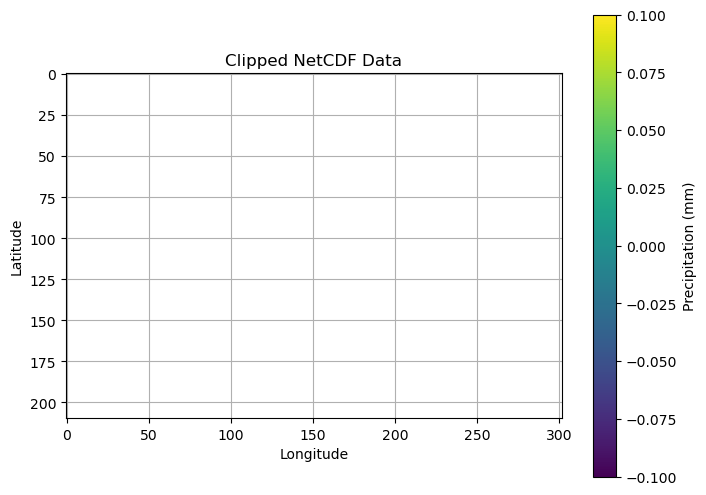

In [58]:
clipped_values = np.count_nonzero(~np.isnan(clipped_data))
print(clipped_values)
plt.figure(figsize=(8, 6))
plt.imshow(clipped_data[0])#, extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clipped NetCDF Data')
plt.grid(True)
plt.show()


In [10]:
mini_shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles', 'Mini_shapes')
mini_shape_file = os.path.join(mini_shape_path, '*.gpkg')
mini_shape_files = glob.glob(mini_shape_file)
gdfs_mini = []

print(mini_shape_files)

for file in mini_shape_files:
    gdf_mini = gpd.read_file(file)
    gdfs_mini.append(gdf_mini)

merged_gdfs_mini = gpd.GeoDataFrame(pd.concat(gdfs_mini, ignore_index=True))
merged_gdfs_mini.plot(color = 'bisque', edgecolor = 'black')

[]


ValueError: No objects to concatenate

In [ ]:
# select one day from the chirps file

mini_1_file = mini_shape_files[100]
mini_1_shape = gpd.read_file(mini_1_file)
mini_1_shape.plot(color= 'bisque')
ds = xr.open_dataset(data_files[0])
ds_day_1 = ds.sel(time = '2018-01-01') # --> Selected day
# print(mini_1_shape)
shape_1 = gpd.read_file(mini_shape_files[0])

clip_1 = shape_1.geometry.values[0]

# print(clip_1)


# with rasterio.open(data_files[0]) as src:
#     # Clip the dataset to the clipping geometry
#     clipped_mini_data, clipped_transform = mask(src, [clip_1], crop=True)

# print(clipped_mini_data)

# geopackage_gdf = gpd.read_file(mini_1_shape)
# clipped_mini, _ = mask(src, geopackage_gdf.geometry.values[0], crop = True, nodata=np.nan)

In [ ]:
ds = xr.open_dataset(data_files[0])  # Assuming data_files contains the list of NetCDF file paths
ds_day_1 = ds.sel(time='2018-01-01')  # Selected day

# Load the GeoPackage shapefile
shape_1 = gpd.read_file(mini_shape_files[0])  # Assuming mini_shape_files contains the path to the shapefile
clip_1 = shape_1.geometry.values[0]  # Assuming the shapefile has only one geometry

# Open the CHIRPS file with rasterio
with rasterio.open(data_files[0]) as src:
    # Clip the CHIRPS data to the clipping geometry
    clipped_mini, _ = mask(src, [clip_1], crop=True, nodata=np.nan)

plt.imshow(clipped_mini, cmap='jet')
plt.colorbar(label='Precipitation (mm)')
plt.title('Clipped CHIRPS Data')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()
